In [2]:
import gymnasium as gym
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

In [3]:
import copy
import pylab
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import argparse, pdb
import numpy as np
import os
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from typing import Callable
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
class DeepSARSA(nn.Module):
    def __init__(self, state_size, action_size):
        super(DeepSARSA, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc_out = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x)
        return x

class DeepSARSAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # 하이퍼 파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9999

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = DeepSARSA(self.state_size, self.action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.lossfn = nn.MSELoss()

    # Epsilon-greedy
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)
        else :
            state = torch.FloatTensor(state).to(self.device)
            with torch.no_grad():
                q_val = self.model(state)
            return torch.argmax(q_val[0]).item()
    
    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        state = torch.FloatTensor(state).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        action = torch.LongTensor([action]).to(self.device)
        next_action = torch.LongTensor([next_action]).to(self.device)
        reward = torch.FloatTensor([reward]).to(self.device)

        predict = self.model(state).gather(1, action.unsqueeze(1)).squeeze(1)

        # done = True일 경우 에피소드 종료 (next_state 없음)
        with torch.no_grad():
            next_q = self.model(next_state).gather(1, next_action.unsqueeze(1)).squeeze(1)
            target = reward + (1-done) * self.discount_factor * next_q

        loss = self.lossfn(predict, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [5]:
root = os.getcwd()
save_dir = root + '\saved_models\deep_sarsa'
print(save_dir)

c:\Users\Lee\PythonWorkspace\RL\saved_models\deep_sarsa


episode: 0.000000, score: -108.456052, epsilon: 0.988
episode: 1.000000, score: -455.179746, epsilon: 0.977
episode: 2.000000, score: -368.678328, epsilon: 0.968
episode: 3.000000, score: -90.326661, epsilon: 0.961
episode: 4.000000, score: -107.854935, epsilon: 0.947
episode: 5.000000, score: -87.870246, epsilon: 0.941
episode: 6.000000, score: -146.888872, epsilon: 0.932
episode: 7.000000, score: -283.693797, epsilon: 0.923
episode: 8.000000, score: -61.025097, epsilon: 0.916
episode: 9.000000, score: -128.966164, epsilon: 0.909
episode: 10.000000, score: -148.761538, epsilon: 0.900
episode: 11.000000, score: -126.396547, epsilon: 0.891
episode: 12.000000, score: -110.365816, epsilon: 0.881
episode: 13.000000, score: -85.162184, epsilon: 0.874
episode: 14.000000, score: -330.484277, epsilon: 0.865
episode: 15.000000, score: -98.890333, epsilon: 0.858
episode: 16.000000, score: -221.828664, epsilon: 0.848
episode: 17.000000, score: -87.883161, epsilon: 0.838
episode: 18.000000, score:

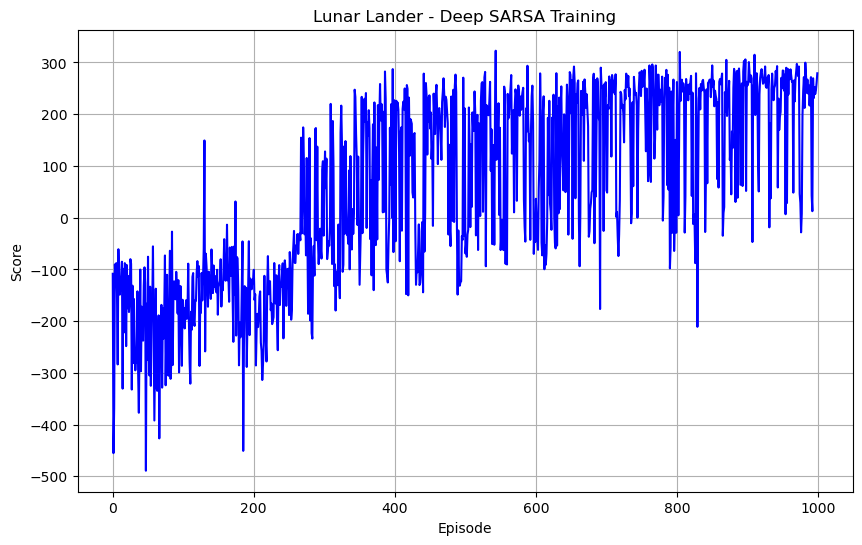

In [18]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DeepSARSAgent(state_size, action_size)

scores, episodes = [], []

EPISODES = 1000
for e in range(EPISODES):
    done = False
    score = 0
    # env 초기화
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        # 현재 상태에 대한 행동 선택
        action = agent.get_action(state)

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_state = np.reshape(next_state, [1, state_size])
        next_action = agent.get_action(next_state)

        # 샘플로 모델 학습
        agent.train_model(state, action, reward, next_state,
                          next_action, done)
        
        score += reward
        state = next_state

        if done:
            print(f"episode: {e:3f}, score: {score:3f}, epsilon: {agent.epsilon:.3f}")
            scores.append(score)
            episodes.append(e)

        # 100 에피소드마다 모델 저장
        if e > 0 and e % 100 == 0:
            file_name = f"lunar_lander_sarsa_ep{e}.pth"
            save_path = os.path.join(save_dir, file_name)
            torch.save(agent.model.state_dict(), save_path)
            print(f"--- Model saved at {save_path} ---")

plt.figure(figsize=(10, 6))
plt.plot(episodes, scores, 'b')
plt.title("Lunar Lander - Deep SARSA Training")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.grid(True)
plt.show()

env.close()

In [8]:
MODEL_PATH = save_dir + "\lunar_lander_sarsa_ep900.pth"

episodes_n = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="human")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

model = DeepSARSA(state_size, action_size).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

for e in range(episodes_n):
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])

    done = False
    score = 0

    while not done:
        state_tensor = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        
        action = torch.argmax(q_values).item()

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        score += reward
        state = np.reshape(next_state, [1, state_size])

    print(f"Episode {e+1}: Score = {score:.2f}")

env.close()

C:\Users\Lee\AppData\Local\Temp\ipykernel_30528\2490086209.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Episode 1: Score = 251.59
Episode 2: Score = 244.83
Episode 3: Score = 274.28
